In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM
import scipy.signal as signal

In [35]:
import pandas as pd

## Step 1: Read the CSV file
#data = pd.read_csv('data.csv') 

## Step 2: Check the structure of the data (optional, but useful for understanding the file)
#print(data.head())  # Print the first 5 rows of the data
#print(data.info())  # Print information about the columns and data types

## Step 3: Separate features (X) and labels (y)
## Assuming the features are in all columns except the last one and the labels are in the last column
#X = data.iloc[:, :-1].values  # Features (all columns except the last one)
#y = data.iloc[:, -1].values   # Labels (the last column)

## Step 4: Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 5: Reshape X_train and X_test if necessary (e.g., for Conv1D)
## For example, if you need 3D input (samples, time steps, features), reshape the data
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adding a new axis for channels
#X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Now the data is ready to be fed into the model



# Simulate RF Signal Data for Three Activities (Walking, Sleeping, Falling)
def simulate_rf_signals(n_samples=1000):
    time = np.linspace(0, 10, n_samples)

    # Walking: Higher frequency signal with noise
    walking_signal = np.sin(2 * np.pi * 1.5 * time) + np.random.normal(0, 0.1, len(time))
    
    # Sleeping: Low frequency and low variation signal
    sleeping_signal = 0.3 * np.sin(2 * np.pi * 0.5 * time) + np.random.normal(0, 0.05, len(time))
    
    # Falling: Sudden change in the signal (simulated by a sharp drop)
    falling_signal = np.concatenate([np.sin(2 * np.pi * 1 * time[:int(n_samples/2)]), np.zeros(int(n_samples/2))])

    return walking_signal, sleeping_signal, falling_signal


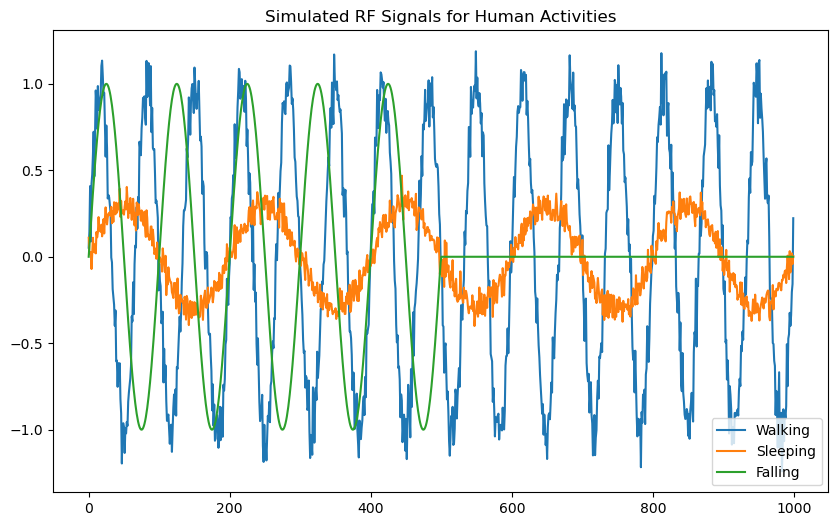

In [36]:
# Generate the data
walking_signal, sleeping_signal, falling_signal = simulate_rf_signals()

# Plot the simulated RF signals
plt.figure(figsize=(10, 6))
plt.plot(walking_signal, label='Walking')
plt.plot(sleeping_signal, label='Sleeping')
plt.plot(falling_signal, label='Falling')
plt.legend()
plt.title('Simulated RF Signals for Human Activities')
plt.show()


In [37]:
# 2. Preprocess the Data: Apply Filtering and FFT (Feature Extraction)
def preprocess_and_extract_features(signal_data):
    # Update: Increase the sampling rate (fs) to avoid exceeding Nyquist frequency
    lowcut = 0.1
    highcut = 20.0  # Adjusted to fit with higher sample rate
    fs = 100.0  # Keep sampling rate, ensure the highcut is below fs/2 (Nyquist)
    
    # Butterworth filter (4th order)
    b, a = signal.butter(4, [lowcut/(fs/2), highcut/(fs/2)], btype='band')
    
    # Filter the signal
    filtered_signal = signal.filtfilt(b, a, signal_data)
    
    # Apply FFT to extract frequency domain features
    fft_signal = np.abs(np.fft.fft(filtered_signal))
    
    return fft_signal[:len(fft_signal)//2]  # Return half of the FFT result (positive frequencies)


In [38]:
# Apply preprocessing and feature extraction to each signal
walking_features = preprocess_and_extract_features(walking_signal)
sleeping_features = preprocess_and_extract_features(sleeping_signal)
falling_features = preprocess_and_extract_features(falling_signal)

In [39]:
# Create dataset and labels
X = np.array([walking_features, sleeping_features, falling_features])
y = np.array([1, 0, 2])  # Labels: 1 = Walking, 0 = Sleeping, 2 = Falling


In [40]:
# Reshape for CNN + LSTM (Add dimension for input shape)
X = X.reshape(X.shape[0], X.shape[1], 1)
print(X.shape)

(3, 500, 1)


In [41]:
# 3. Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [42]:
# One-hot encode labels for classification
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [43]:
# 4. Build CNN + LSTM Model for Classification
model = Sequential()

In [44]:
# Add 1D Convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

In [45]:
# Add LSTM layer for capturing time dependencies
model.add(LSTM(100, return_sequences=True))
model.add(Flatten())


In [46]:
# Output layer with softmax activation for multi-class classification
model.add(Dense(3, activation='softmax'))


In [47]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [48]:
# 5. Train the Model
history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_split=0.2)


Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 1.2718 - accuracy: 0.0000e+00 - val_loss: 2.2839 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 141ms/step - loss: 0.1592 - accuracy: 1.0000 - val_loss: 4.2888 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 141ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 6.3541 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 141ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 8.3107 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 117ms/step - loss: 9.8939e-05 - accuracy: 1.0000 - val_loss: 10.1554 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 125ms/step - loss: 1.0371e-05 - accuracy: 1.0000 - val_loss: 11.9037 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 125ms/step - loss: 1.1921e-06 - accuracy: 1.0000 - val_loss: 13.5590 - v

In [49]:
# 6. Evaluate the Model on Test Data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

1/1 [==============================] - 1s 1s/step


In [50]:
# 7. Confusion Matrix and Other Performance Metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


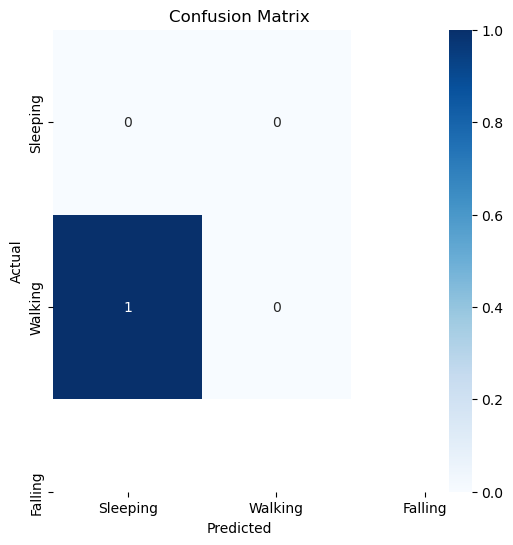

In [51]:
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Sleeping', 'Walking', 'Falling'], yticklabels=['Sleeping', 'Walking', 'Falling'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [52]:
# Calculate accuracy, precision, recall, and F1-score (set zero_division=1 to handle undefined cases)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')


In [53]:
# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.00
Precision: 1.00
Recall: 0.00
F1-Score: 0.00
